In [ ]:
!pip install tinymlgen
import pandas as pd
import numpy as np
import os
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from tinymlgen import port
import seaborn as sns
import matplotlib.pyplot as plt


In [ ]:
# Carico il dataset (session storage)
df = pd.read_csv("dati_ormeggio_etichettati.csv")

print("Colonne presenti nel dataset:", df.columns.tolist())

# Distinzione delle colonne
FEATURES = ['Accelerometro_X', 'Accelerometro_Y', 'Accelerometro_Z',
            'Giroscopio_X', 'Giroscopio_Y', 'Giroscopio_Z', 'Solcometro']
TARGET = "Ormeggio"

# Conversione in array
X = df[FEATURES].values
y = df[TARGET].values

# Normalizzazione dei dati (media e dev. stand.)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

#(righe, colonne)
print(f"Shape X_scaled: {X_scaled.shape}")


Colonne presenti nel dataset: ['Accelerometro_X', 'Accelerometro_Y', 'Accelerometro_Z', 'Giroscopio_X', 'Giroscopio_Y', 'Giroscopio_Z', 'Solcometro', 'Ormeggio']
Shape X_scaled: (200, 7)


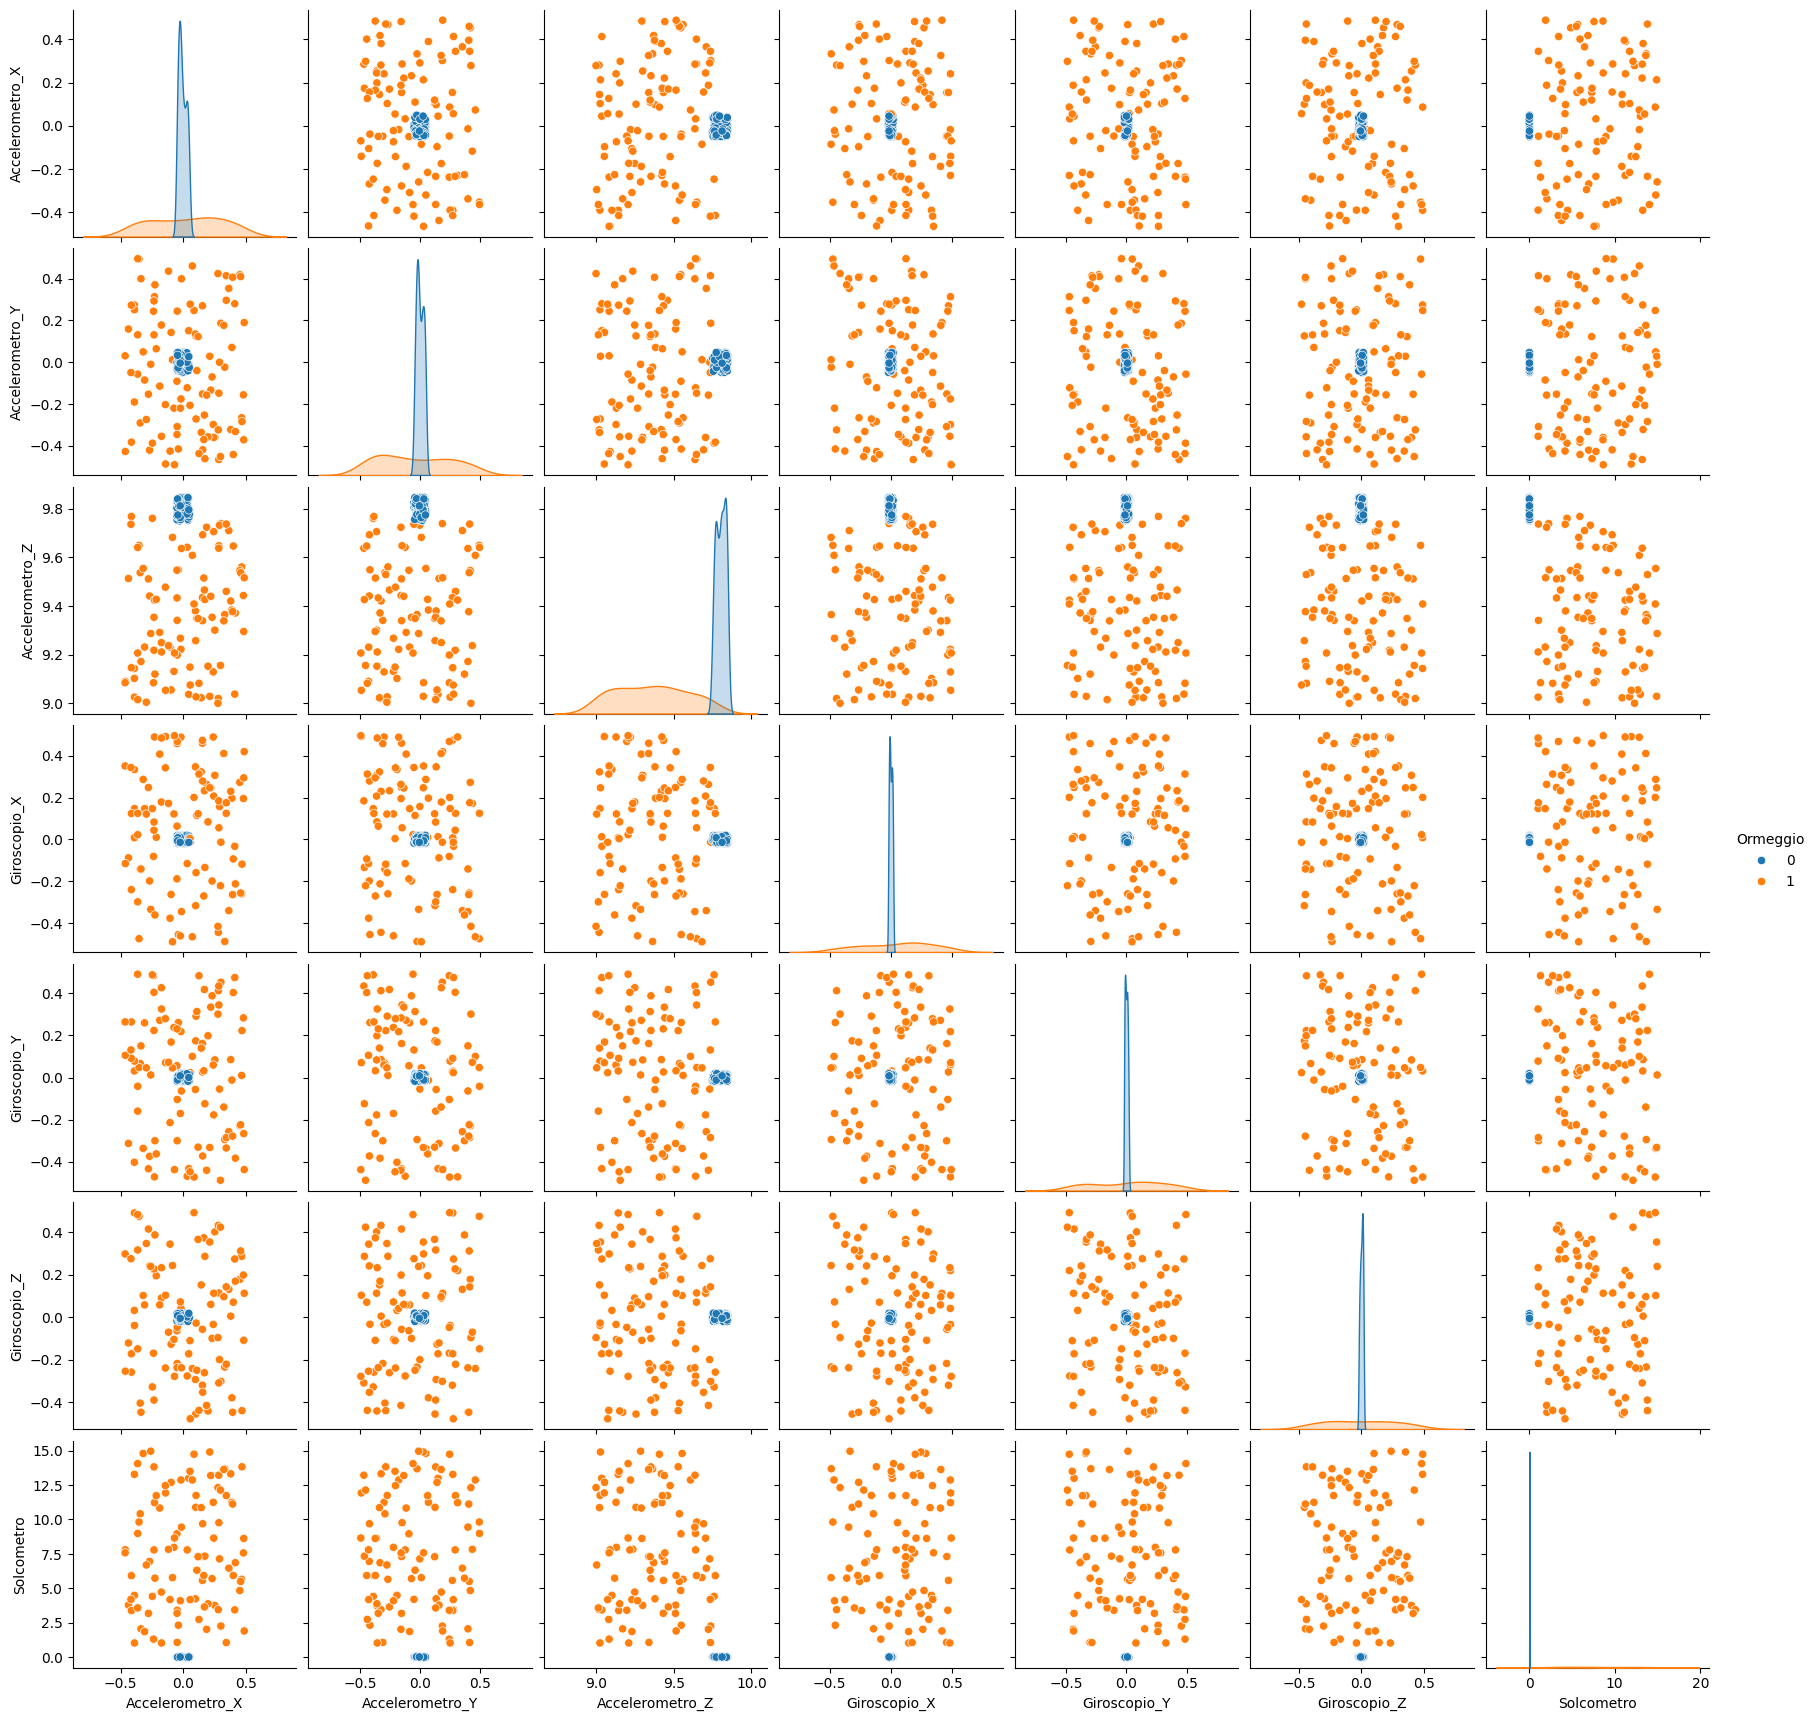

In [ ]:
# Capire la distribuzione dei dati
sns.pairplot(df, hue="Ormeggio", diag_kind="kde")
plt.show()


In [ ]:
# Suddivisione in traning e test
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Controllo finale
print(f"Shape X_train: {X_train.shape}, Shape X_test: {X_test.shape}")



Shape X_train: (160, 7), Shape X_test: (40, 7)


In [ ]:
# Creo la rete definendone i nodi
model = keras.Sequential([
    keras.layers.Dense(8, activation='elu', input_shape=(7,)),
    keras.layers.Dense(4, activation='elu'),
    keras.layers.Dense(1, activation='sigmoid')
])

# Compilazione del modello
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


# Addestramento della rete neurale
history = model.fit(X_train, y_train, epochs=17, batch_size=4, validation_data=(X_test, y_test))


Epoch 1/17
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.3809 - loss: 0.7936 - val_accuracy: 0.5500 - val_loss: 0.8702
Epoch 2/17
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8023 - loss: 0.6284 - val_accuracy: 0.6500 - val_loss: 0.6946
Epoch 3/17
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8396 - loss: 0.5284 - val_accuracy: 0.8000 - val_loss: 0.5640
Epoch 4/17
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8654 - loss: 0.4726 - val_accuracy: 0.8250 - val_loss: 0.4641
Epoch 5/17
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8907 - loss: 0.3958 - val_accuracy: 0.8500 - val_loss: 0.3911
Epoch 6/17
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8596 - loss: 0.3751 - val_accuracy: 0.8750 - val_loss: 0.3310
Epoch 7/17
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8873 - loss: 0.3187 - val_accuracy: 0.9000 - val_loss: 0.2822
Epoch 8/17
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9314 - loss: 0.2530 - val_accuracy: 0.9000 - val_loss:

In [ ]:
# Valutazione delle prestazioni
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Accuracy sul test set: {accuracy:.2f}')


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 1.0000 - loss: 0.0692 
Accuracy sul test set: 1.00


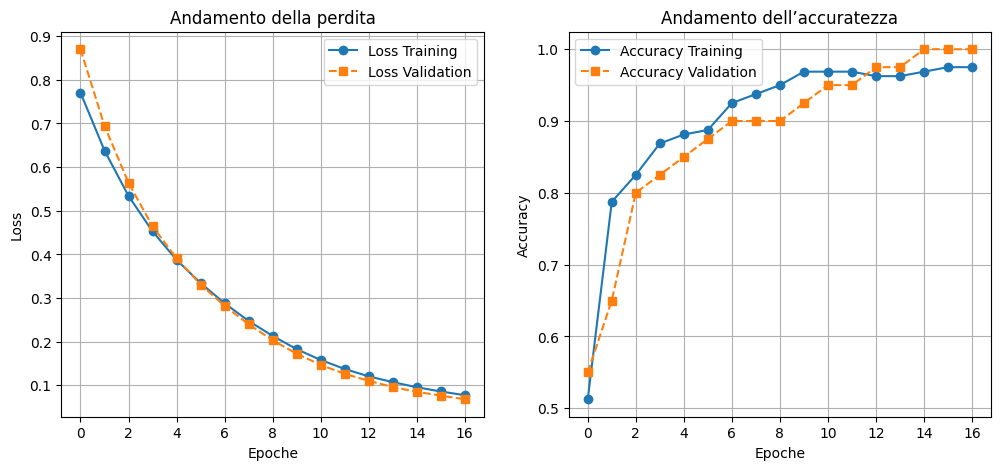

In [ ]:

# Grafico della perdita e dell'accuratezza
plt.figure(figsize=(12, 5))

# Andamento della perdita (loss)
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Loss Training', linestyle='-', marker='o')
plt.plot(history.history['val_loss'], label='Loss Validation', linestyle='--', marker='s')
plt.xlabel("Epoche")
plt.ylabel("Loss")
plt.legend()
plt.title("Andamento della perdita")
plt.grid(True)

# Andamento dell'accuratezza (accuracy)
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Accuracy Training', linestyle='-', marker='o')
plt.plot(history.history['val_accuracy'], label='Accuracy Validation', linestyle='--', marker='s')
plt.xlabel("Epoche")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Andamento dell’accuratezza")
plt.grid(True)

plt.show()


In [ ]:


# Conversione del modello
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()

c_code = port(model,
              pretty_print=True,
              variable_name='ormeggio_model')

# Lo salvo in un file .h
with open("ormeggio_model.h", "w") as f:
    f.write(c_code)

print("Modello esportato con successo")




Saved artifact at '/tmp/tmpiyk4rsft'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 7), dtype=tf.float32, name='keras_tensor_36')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  137229980422736: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137229980432528: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137229980428880: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137229980433296: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137229980433872: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137229980426768: TensorSpec(shape=(), dtype=tf.resource, name=None)


Saved artifact at '/tmp/tmpa948mcs8'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 7), dtype=tf.float32, name='keras_tensor_36')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  137229980422736: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137229980432528: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137229980428880: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137229980433296: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137229980433872: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137229980426768: TensorSpec(shape=(), dtype=tf.resource, name=None)


✅ Modello esportato con successo in formato TinyML!
